In [1]:
%%bash

pip install xgbfir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 2.6 MB/s eta 0:00:00


In [2]:
import io
import os
import pathlib
import requests
import tarfile


import hyperopt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import sparse
from sklearn import feature_extraction, linear_model, metrics, model_selection, pipeline, preprocessing, tree
import xgboost as xgb
import xgbfir


In [3]:
DATA_ARCHIVE = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
DATA_DIR = pathlib.Path("./sample_data")

response = requests.get(DATA_ARCHIVE, stream=True)
with tarfile.open(fileobj=response.raw, mode="r|gz") as t:
    t.extractall(DATA_DIR)


In [4]:
def _reviews_to_df(filepath, sentiment):
    d = {"text": [], "sentiment": []}
    review_filepaths = sorted(filepath.glob("*.txt"))
    for review_filepath in review_filepaths:
        with open(review_filepath, 'r') as f:
            review = f.read()
        d["text"].append(review)
        d["sentiment"].append("positive" if sentiment == "pos" else "negative")
    df = pd.DataFrame.from_dict(d)
    return df


def _combine_reviews():
    dfs = []
    for split in ["train", "test"]:
        for sentiment in ["pos", "neg"]:
            df = _reviews_to_df(DATA_DIR / "aclImdb" / split / sentiment, sentiment)
            dfs.append(df)
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df


def partition_reviews(seed=42, test_size=0.2):
    combined_df = _combine_reviews()
    random_state = np.random.RandomState(seed)
    train_df, _val_df = model_selection.train_test_split(
        combined_df,
        random_state=random_state,
        shuffle=True,
        stratify=combined_df["sentiment"],
        test_size=test_size
    )

    # split the _val_df equally into val and test sets
    val_df, test_df = model_selection.train_test_split(
        _val_df,
        random_state=random_state,
        shuffle=True,
        stratify=_val_df["sentiment"],
        test_size=0.5
    )

    return train_df, val_df, test_df


In [5]:
train_df, val_df, test_df = partition_reviews(seed=42)

In [ ]:
feature_extraction.text.TfidfVectorizer?

In [22]:
pd.DataFrame.to

In [31]:
vectorizer_hyperparams = {
    "lowercase": True,
    "max_df": 0.9, # ignore words that show up in more than 90% of reviews
    "min_df": 0.1, # ignore words than show up in less than 10% of reviews
    "norm": "l2", # normalize rows using
    "dtype": np.float32,
}

vectorizer = feature_extraction.text.TfidfVectorizer(
    **vectorizer_hyperparams,
)

features_preprocessing = pipeline.make_pipeline(
    vectorizer,
    preprocessing.FunctionTransformer(
        lambda csr: csr.toarray(),
        lambda arr: sparse.csr_matrix(arr),
        feature_names_out="one-to-one"
    ),
    preprocessing.FunctionTransformer(
        lambda arr: pd.DataFrame(arr, columns=vectorizer.get_feature_names_out()),
        lambda df: df.to_numpy(),
        feature_names_out="one-to-one"
    )
)

label_encoder = preprocessing.LabelEncoder()

In [32]:
X_train = features_preprocessing.fit_transform(train_df.loc[:, "text"])
y_train = label_encoder.fit_transform(train_df.loc[:, "sentiment"])

X_val = features_preprocessing.transform(val_df.loc[:, "text"])
y_val = label_encoder.transform(val_df.loc[:, "sentiment"])

X_test = features_preprocessing.transform(test_df.loc[:, "text"])
y_test = label_encoder.transform(test_df.loc[:, "sentiment"])


In [33]:
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [35]:
print(f"Training accuracy: {xgb_classifier.score(X_train, y_train)}")
print(f"Validation accuracy: {xgb_classifier.score(X_val, y_val)}")

Training accuracy: 0.910925
Validation accuracy: 0.7668


In [ ]:
xgbfir.saveXgbFI?

In [36]:
xgbfir.saveXgbFI(
    xgb_classifier,
    feature_names=X_train.columns,
    OutputXlsxFile="feature-interactions.xlsx"
)

In [37]:
(pd.read_excel("feature-interactions.xlsx")
   .sort_values(by="Average Rank")
   .head(n=10))

,Interaction,Gain,FScore,wFScore,Average wFScore,Average Gain,Expected Gain,Gain Rank,FScore Rank,wFScore Rank,Avg wFScore Rank,Avg Gain Rank,Expected Gain Rank,Average Rank,Average Tree Index,Average Tree Depth
1,great,3828.365358,50,14.323310,0.286466,76.567307,2168.077534,2,15,1,9,2,2,5.166667,24.640000,2.820000
0,bad,7369.802022,48,12.517169,0.260774,153.537542,6818.808479,1,20,2,12,1,1,6.166667,27.916667,3.104167
4,best,1519.028118,46,10.615860,0.230780,33.022350,731.163805,5,23,4,19,6,3,10.000000,38.847826,3.282609
3,nothing,1553.368864,32,8.737250,0.273039,48.542777,630.533421,4,39,7,11,3,5,11.500000,22.437500,3.500000
5,even,1197.076372,50,9.278163,0.185563,23.941527,508.788243,6,16,6,34,13,6,13.500000,28.280000,3.820000
2,no,1559.639828,43,8.005700,0.186179,36.270694,694.660549,3,31,9,33,4,4,14.000000,33.162791,3.930233
6,well,1157.104403,55,9.740730,0.177104,21.038262,394.224477,7,8,5,39,18,7,14.000000,34.127273,3.872727
7,love,1133.108863,35,6.520885,0.186311,32.374539,366.070067,8,36,14,32,7,8,17.500000,24.885714,3.800000
14,why,783.213651,30,7.571940,0.252398,26.107122,305.276818,15,49,11,13,10,11,18.166667,32.866667,3.833333
8,just,962.816436,51,6.595598,0.129325,18.878754,363.244134,9,11,12,55,20,9,19.333333,40.490196,4.019608


In [38]:
(pd.read_excel("feature-interactions.xlsx", sheet_name="Interaction Depth 1")
   .sort_values(by="Average Rank")
   .head(n=10))

,Interaction,Gain,FScore,wFScore,Average wFScore,Average Gain,Expected Gain,Gain Rank,FScore Rank,wFScore Rank,Avg wFScore Rank,Avg Gain Rank,Expected Gain Rank,Average Rank,Average Tree Index,Average Tree Depth
2,great|nothing,2043.410527,3,1.158850,0.386283,681.136842,1093.523951,3,11,4,29,3,2,8.666667,2.666667,3.333333
0,bad|great,15325.010326,14,3.667666,0.261976,1094.643595,7689.247445,1,1,1,48,1,1,8.833333,1.071429,1.785714
6,bad|best,922.272525,3,0.855654,0.285218,307.424175,645.806137,7,13,14,44,22,3,17.166667,24.000000,3.000000
16,bad|well,509.561035,1,0.862722,0.862722,509.561035,439.609719,17,62,13,2,7,6,17.833333,4.000000,1.000000
1,great|great,2114.908824,3,0.622551,0.207517,704.969608,421.798224,2,10,33,55,2,8,18.333333,10.333333,1.666667
9,just|no,828.439743,2,0.777729,0.388864,414.219872,344.704600,10,34,18,27,13,10,18.666667,3.500000,2.000000
8,best|thing,835.530395,2,0.707353,0.353676,417.765198,344.890727,9,33,23,32,10,9,19.333333,1.500000,3.500000
11,great|just,656.386322,1,0.657673,0.657673,656.386322,431.687306,12,60,27,11,4,7,20.166667,2.000000,2.000000
5,even|great,1094.808589,3,0.646344,0.215448,364.936196,555.721789,6,12,30,53,17,4,20.333333,1.333333,3.333333
4,no|nothing,1146.964356,2,0.558025,0.279013,573.482178,515.663649,5,31,39,45,5,5,21.666667,0.000000,3.500000


In [43]:
_interaction_constraints = (
    pd.read_excel("feature-interactions.xlsx", sheet_name="Interaction Depth 1")
      .sort_values(by="Average Rank")
      .head(n=3)
      .loc[:, "Interaction"]
      .str
      .split('|')
      .to_list()
)

xgb_classifier = xgb.XGBClassifier(
    max_depth=2,
    interaction_constraints=_interaction_constraints,
)
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=[['great', 'nothing'], ['bad', 'great'],
                                       ['bad', 'best']],
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [44]:
print(f"Training accuracy: {xgb_classifier.score(X_train, y_train)}")
print(f"Validation accuracy: {xgb_classifier.score(X_val, y_val)}")

Training accuracy: 0.7566
Validation accuracy: 0.7562


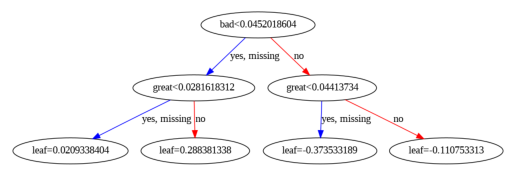

In [45]:
_ = xgb.plot_tree(
    xgb_classifier,
    num_trees=0
)

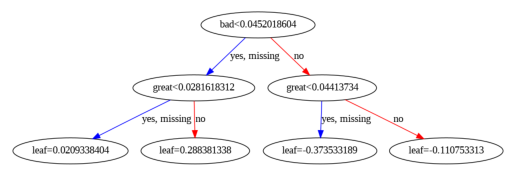

In [47]:
_xgb_classifier = xgb.XGBClassifier(
    max_depth=2,
)
_xgb_classifier.fit(X_train, y_train)

_ = xgb.plot_tree(
    _xgb_classifier,
    num_trees=0
)

In [41]:
(pd.read_excel("feature-interactions.xlsx", sheet_name="Interaction Depth 2")
   .sort_values(by="Average Rank")
   .head(n=10))

,Interaction,Gain,FScore,wFScore,Average wFScore,Average Gain,Expected Gain,Gain Rank,FScore Rank,wFScore Rank,Avg wFScore Rank,Avg Gain Rank,Expected Gain Rank,Average Rank,Average Tree Index,Average Tree Depth
2,bad|great|nothing,4952.731930,1,0.580300,0.580300,4952.731930,2874.070339,3,16,15,10,1,1,7.666667,0.0,2.0
4,bad|even|great,2621.122562,1,0.578438,0.578438,2621.122562,1516.157114,5,17,16,11,2,2,8.833333,1.0,2.0
7,bad|great|just,1851.049713,2,0.762580,0.381290,925.524856,1061.121905,8,6,2,29,14,6,10.833333,1.5,2.5
5,great|no|nothing,2512.138792,2,0.558025,0.279013,1256.069396,1143.118432,6,5,18,36,9,5,13.166667,0.0,3.5
16,bad|best|thing,1014.863983,1,0.633903,0.633903,1014.863983,643.325207,17,24,10,8,13,7,13.166667,3.0,2.0
0,bad|bad|great,11513.829525,5,0.608229,0.121646,2302.765905,1310.898493,1,1,12,59,3,4,13.333333,1.0,2.0
27,bad|love|well,703.046600,1,0.714063,0.714063,703.046600,502.019737,28,33,3,2,23,10,16.500000,4.0,2.0
12,even|great|plot,1173.564987,1,0.455483,0.455483,1173.564987,534.538579,13,21,28,22,10,8,17.000000,1.0,3.0
10,best|no|nothing,1260.535156,1,0.408925,0.408925,1260.535156,515.464339,11,20,32,25,8,9,17.500000,0.0,4.0
1,bad|great|great,7565.717529,4,0.425221,0.106305,1891.429382,1393.188768,2,2,31,65,4,3,17.833333,0.5,2.5
